In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate


from tqdm import tqdm
from torch.optim import Adam
import gc
from rtmag.train.diff_torch_batch import curl, divergence
from torchmetrics.regression import ConcordanceCorrCoef, MeanSquaredError

In [2]:
meta_path = Path("/home/usr/workspace/base/uno_pi_cc_hnorm_1_unit_aug_ccc_square")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

# b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
idx = 239

data_path = Path('/mnt/f/isee_dataset/12673/input/').glob('*.npz')
data_path = sorted(data_path)

label_path = Path('/mnt/f/isee_dataset/12673/label/').glob('*.npz')
label_path = sorted(label_path)

print(data_path[idx].name)
print(label_path[idx].name)

input_12673_20170906_083600.npz
label_12673_20170906_083600.npz


In [4]:
inputs = np.load(data_path[idx])
model_input = torch.from_numpy(inputs['input'])[None, ...]

b_norm = torch.max(torch.abs(model_input)).item()
# [batch_size, 3, 513, 257, 1]
model_input = model_input[:, :, :-1, :-1, :] / b_norm # remove duplicated periodic boundary
model_input = model_input.to(device)
model_input = torch.permute(model_input, (0, 4, 3, 2, 1))

In [5]:
labels = model(model_input).detach()
labels.shape

torch.Size([1, 256, 256, 512, 3])

In [6]:
model = model.train()
optimizer = Adam(model.parameters(), lr=args.training['learning_late'])

with tqdm(range(20)) as tqdm_loader_train:
        for iteration in tqdm_loader_train:
                gc.collect()
                torch.cuda.empty_cache()

                loss = {}
                # [b, z, y, x, 3] 
                outputs = model(model_input).to(device)

                # [b, z, y, x, 3] -> [b, z, ...]
                opts = torch.flatten(outputs, start_dim=2)
                lbls = torch.flatten(labels, start_dim=2)

                # [b, z, ...] -> [b, ..., z]
                opts = torch.permute(opts, (0, 2, 1))
                lbls = torch.permute(lbls, (0, 2, 1))

                # mse loss
                mse = MeanSquaredError().to(device)
                loss_mse = torch.mean(mse(opts.flatten(), lbls.flatten()))
                loss['mse'] = loss_mse

                # ccc loss
                # ccc = ConcordanceCorrCoef(num_outputs=opts.shape[-1]).to(device)
                # loss_ccc = 0.0
                # if args.training.get('ccc_square', False):
                #         for i in range(opts.shape[0]):
                #                 loss_ccc += torch.mean(torch.square(1.0 - ccc(opts[i], lbls[i])))
                # else:
                #         for i in range(opts.shape[0]):
                #                 loss_ccc += torch.mean(torch.abs(1.0 - ccc(opts[i], lbls[i])))
                # loss_ccc /= opts.shape[0]
                # loss['ccc'] = loss_ccc
                
                # [b, z, y, x, 3] -> [b, x, y, z, 3]
                b = torch.permute(outputs, (0, 3, 2, 1, 4))
                B = torch.permute(labels, (0, 3, 2, 1, 4))


                # unnormalization
                if args.data["dataset_name"] == "Hnorm_Square_Unit_Aug":
                        divisor = (1 / np.arange(1, b.shape[2] + 1)**2 ).reshape(1, 1, -1, 1).astype(np.float32)
                else:
                        divisor = (1 / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1).astype(np.float32)
                        
                divisor = torch.from_numpy(divisor).to(device)
                b = b * divisor
                B = B * divisor
                
                # boundary condition loss
                loss_bc = 0.0
                # bottom (z=0)
                loss_bc += torch.mean(torch.square(b[:, :, :, 0, :] - B[:, :, :, 0, :]))
                loss['bc'] = loss_bc

                dx = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)
                dy = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)
                dz = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)

                # force-free loss
                bx, by, bz = b[..., 0], b[..., 1], b[..., 2]
                jx, jy, jz = curl(bx, by, bz, dx, dy, dz)
                b = torch.stack([bx, by, bz], -1)
                j = torch.stack([jx, jy, jz], -1)

                jxb = torch.cross(j, b, -1)
                loss_ff = (jxb**2).sum(-1) / ((b**2).sum(-1) + 1e-7)
                loss_ff = torch.mean(loss_ff)
                loss['ff'] = loss_ff

                # divergence-less loss
                div_b = divergence(bx, by, bz, dx, dy, dz)
                loss_div = torch.mean(torch.square(div_b))
                loss['div'] = loss_div


                los = 0.01*args.training['w_mse']*loss['mse'] \
                + args.training['w_bc']*loss['bc'] \
                + 100*args.training['w_ff']*loss['ff'] \
                + 100*args.training['w_div']*loss['div'] \
                
                print(f"iter:{iteration}, loss:{los.item():2g}, mse:{loss_mse.item():.2g}, bc:{loss_bc.item():.2g}, ff:{loss_ff.item():.2g}, div:{loss_div.item():.2g}")

                optimizer.zero_grad()
                los.backward()
                optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

iter:0, loss:0.00119064, mse:0, bc:0, ff:8.8e-06, div:3.1e-06


  5%|▌         | 1/20 [00:02<00:44,  2.36s/it]

iter:1, loss:0.00171149, mse:0.0052, bc:5e-05, ff:8e-06, div:3.6e-06


 10%|█         | 2/20 [00:03<00:26,  1.46s/it]

iter:2, loss:0.00116771, mse:0.0027, bc:5e-06, ff:7.9e-06, div:3e-06


 15%|█▌        | 3/20 [00:04<00:20,  1.21s/it]

iter:3, loss:0.00140692, mse:0.00014, bc:2.7e-05, ff:8.2e-06, div:3.2e-06


 20%|██        | 4/20 [00:05<00:17,  1.11s/it]

iter:4, loss:0.00141993, mse:0.0002, bc:2.8e-05, ff:8.2e-06, div:3.2e-06


 25%|██▌       | 5/20 [00:05<00:15,  1.03s/it]

iter:5, loss:0.00121963, mse:0.00012, bc:1.1e-05, ff:8e-06, div:3e-06


 30%|███       | 6/20 [00:06<00:13,  1.03it/s]

iter:6, loss:0.00113419, mse:0.00038, bc:4.1e-06, ff:7.9e-06, div:3e-06


 35%|███▌      | 7/20 [00:07<00:12,  1.08it/s]

iter:7, loss:0.00118731, mse:0.0019, bc:8.9e-06, ff:7.8e-06, div:3e-06


 40%|████      | 8/20 [00:08<00:10,  1.11it/s]

iter:8, loss:0.00124613, mse:0.0036, bc:1.4e-05, ff:7.7e-06, div:3e-06


 45%|████▌     | 9/20 [00:09<00:09,  1.14it/s]

iter:9, loss:0.00122172, mse:0.0041, bc:1.3e-05, ff:7.6e-06, div:2.9e-06


 50%|█████     | 10/20 [00:10<00:08,  1.15it/s]

iter:10, loss:0.00114218, mse:0.0032, bc:7e-06, ff:7.5e-06, div:2.9e-06


 55%|█████▌    | 11/20 [00:10<00:07,  1.17it/s]

iter:11, loss:0.00108272, mse:0.0017, bc:2.8e-06, ff:7.4e-06, div:2.9e-06


 60%|██████    | 12/20 [00:11<00:06,  1.16it/s]

iter:12, loss:0.00108257, mse:0.00053, bc:3.3e-06, ff:7.5e-06, div:2.9e-06


 65%|██████▌   | 13/20 [00:12<00:06,  1.14it/s]

iter:13, loss:0.00113045, mse:0.00017, bc:7.4e-06, ff:7.6e-06, div:2.9e-06


 70%|███████   | 14/20 [00:13<00:05,  1.16it/s]

iter:14, loss:0.00114338, mse:0.0003, bc:8.4e-06, ff:7.6e-06, div:2.9e-06


 75%|███████▌  | 15/20 [00:14<00:04,  1.17it/s]

iter:15, loss:0.00110042, mse:0.00035, bc:4.9e-06, ff:7.6e-06, div:2.9e-06


 80%|████████  | 16/20 [00:15<00:03,  1.18it/s]

iter:16, loss:0.00105259, mse:0.00024, bc:1.6e-06, ff:7.4e-06, div:2.9e-06


 85%|████████▌ | 17/20 [00:16<00:02,  1.18it/s]

iter:17, loss:0.00103965, mse:0.00019, bc:1.6e-06, ff:7.3e-06, div:2.9e-06


 90%|█████████ | 18/20 [00:18<00:02,  1.45s/it]

iter:18, loss:0.00105706, mse:0.00046, bc:4.3e-06, ff:7.2e-06, div:2.9e-06


 95%|█████████▌| 19/20 [00:19<00:01,  1.32s/it]

iter:19, loss:0.00106763, mse:0.00097, bc:5.9e-06, ff:7.1e-06, div:2.9e-06


100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


In [7]:
model_output = model(model_input)
# [512, 256, 256, 3]
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [8]:
print(b_norm)

4414.97998046875


In [9]:
B = np.load(label_path[idx])["label"][:, :-1, :-1, :-1]
B = B.transpose(1, 2, 3, 0)
B.shape

(512, 256, 256, 3)

In [10]:
evaluate(b, B)

C_vec     : 0.9528
C_cs      : 0.7016
E_n'      : 0.5825
E_m'      : -0.3268
eps       : 0.9367
CW_sin    : 0.7978
L_f       : 137.5825
L_d       : 55.2798
l2_err    : 0.3049


{'C_vec': 0.9528142971862247,
 'C_cs': 0.7016230316681407,
 "E_n'": 0.5825274451296936,
 "E_m'": -0.3267551428029065,
 'eps': 0.93667127522327,
 'CW_sin': 0.7977773443644762,
 'L_f': 137.5825068614566,
 'L_d': 55.27983785493886,
 'l2_err': 0.30488425449680967}

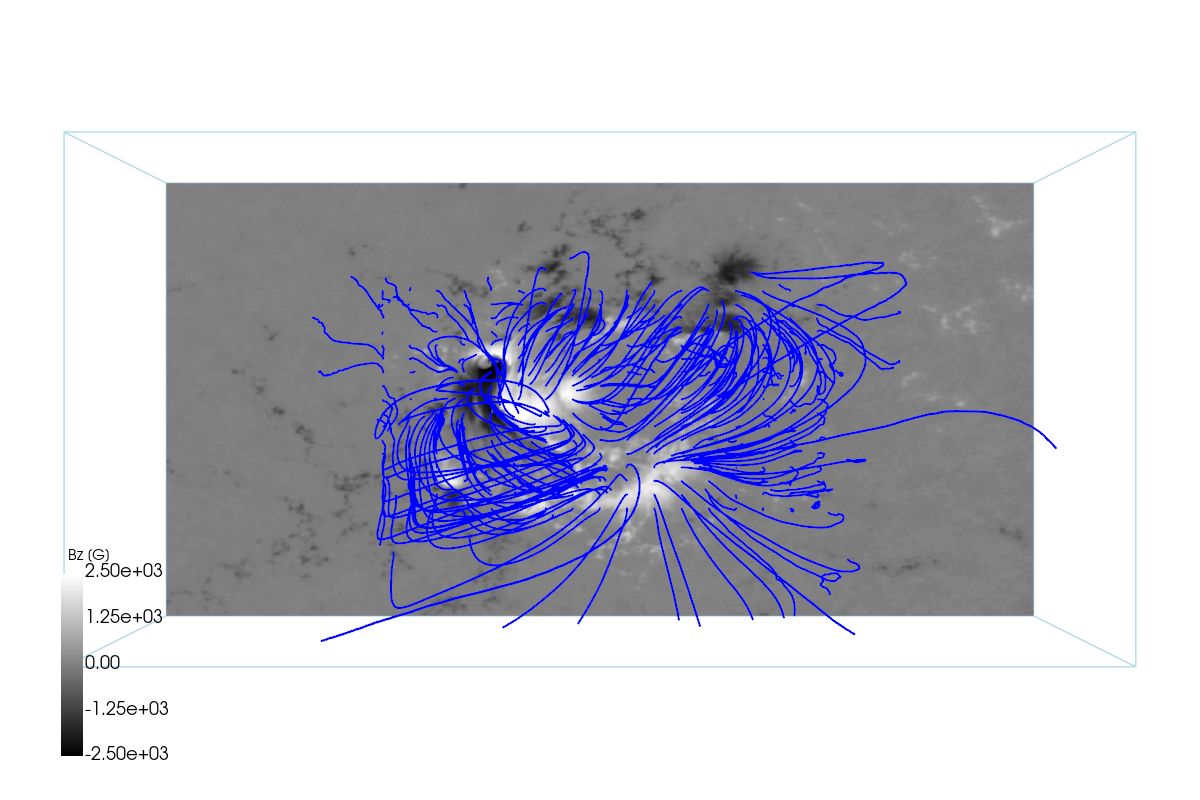

In [13]:
vmin=-2500
vmax=2500
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

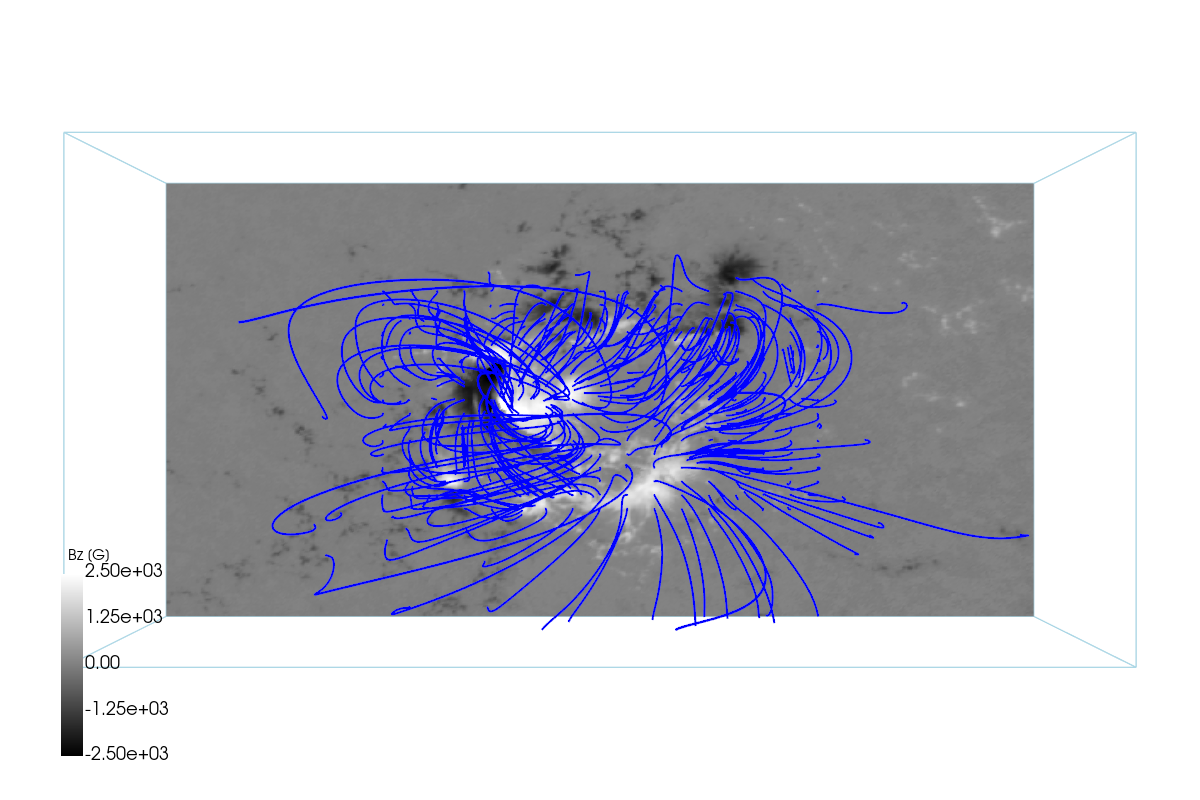

In [14]:
vmin=-2500
vmax=2500
i_siz=B.shape[0] / 2
j_siz=B.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = B[..., 0]
by = B[..., 1]
bz = B[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

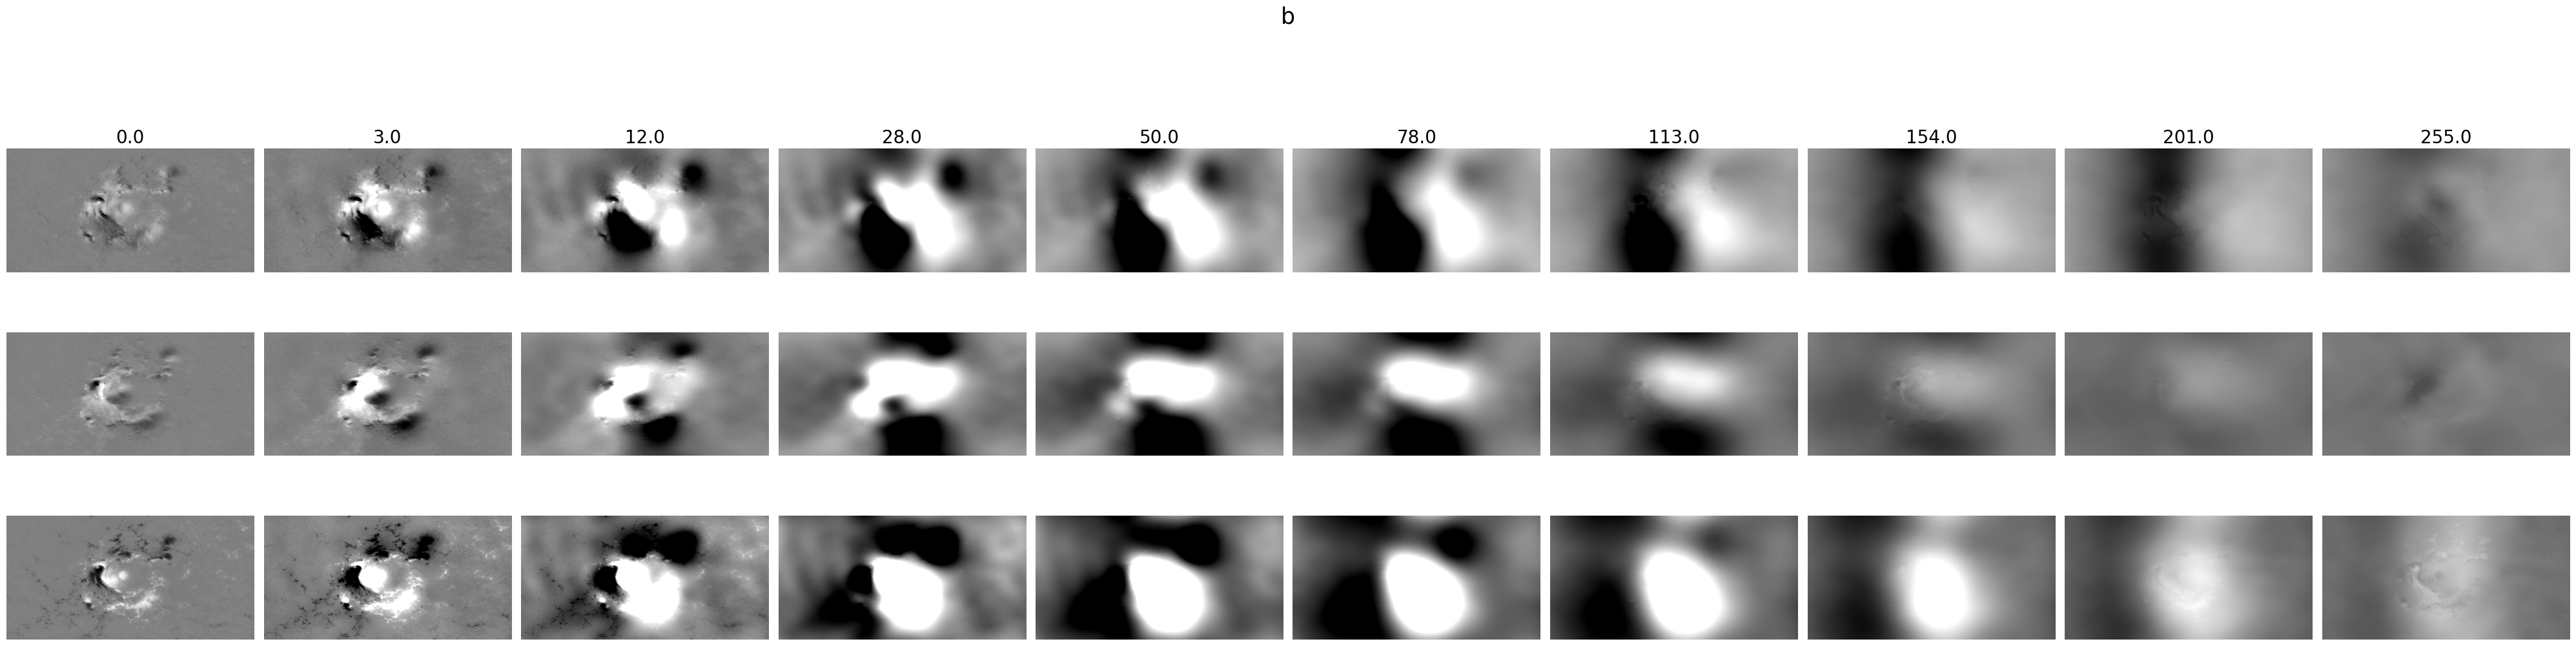

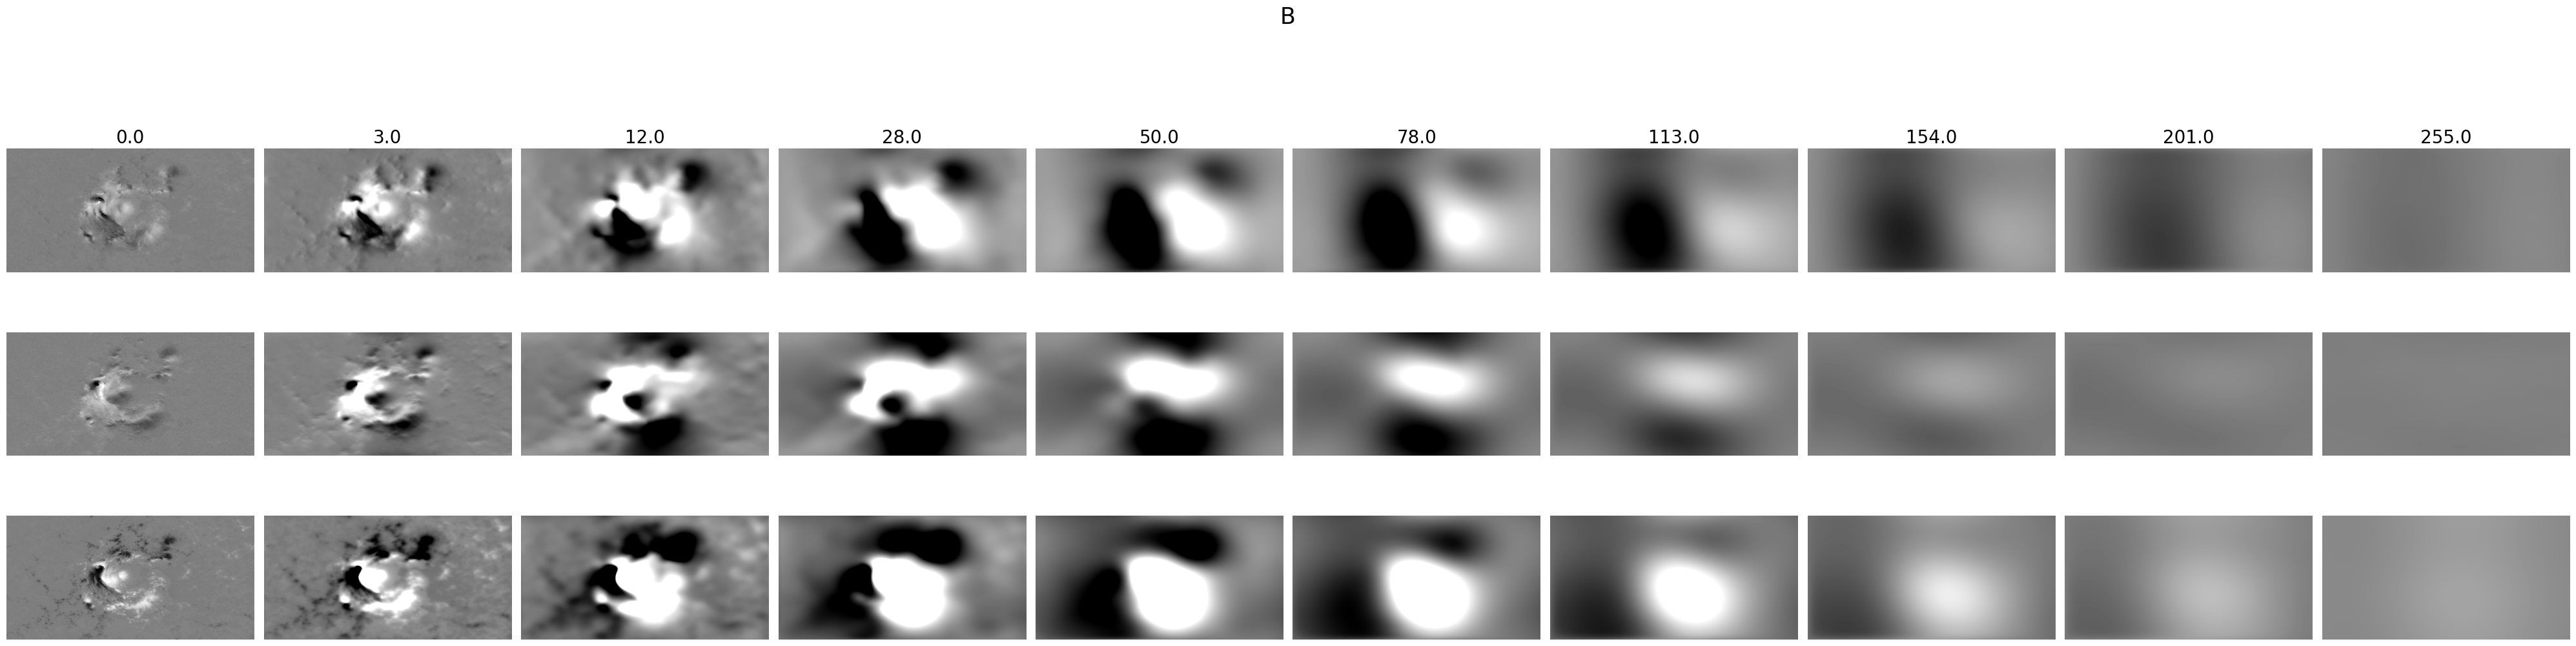

In [10]:
plot_sample(b, B, v_mm=2500)